In [1]:
from carbon.helpers.stdimports import *
from carbon.helpers import j, strategy, pdread, pdcols, fsave, listdir, Params
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS

plt.rcParams['figure.figsize'] = [12,6]
plt_style('seaborn-v0_8-dark', 'seaborn-dark')
print_version(require="2.2.4")

[stdimports] imported np, pd, plt, os, sqrt, exp, log
Carbon v2.2.5-BETA0 (27/Jan/2022)
CarbonSimulatorUI v2.5 (25/Jan/2023)
CarbonOrderUI v1.6.1 (21/Jan/2023)


# Carbon Simulation - Demo 7-4 
_[frozen_20230127][frozen]: this notebook on [Binder][frozen_nb] and on [github][frozen_gh]_

Use **Run -- Run All Cells** in the menu above to run the notebook, then adjust the simulation parameters using the widgets provided. You can find **further usage instructions at the end of this notebook**, and throughout the notebook.

Further resources are (1) the github repo [github:carbon-simulator-binder][repob] associated with this binder, (2) the main simulator repo [github:carbon-simulator][repo], (3) the carbon package [pypi:carbon-simulator][simpypi] and finally (4) the ["Carbon Simulator" presentation][presn]

[presn]:https://github.com/bancorprotocol/carbon-simulator/blob/beta/resources/notes/202301%20Simulating%20Carbon.pdf
[simpypi]:https://pypi.org/project/carbon-simulator/
[repo]:https://github.com/bancorprotocol/carbon-simulator
[repob]:https://github.com/bancorprotocol/carbon-simulator-binder
[frozen]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230127
[frozen_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230127?labpath=Frozen%2FDemo7-4%2FDemo7-4.ipynb
[frozen_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/frozen_20230127/Frozen/Demo7-4/Demo7-4.ipynb

## Setup

In [2]:
# remove at next update
sim_params = SIM_DEFAULT_PARAMS.params
sim_params["plotValueCsh"] = True

import datetime 
fname = lambda data, col: f"{datetime.datetime.now().strftime('%m%d-%H%M%S')}-{data}-{col.replace('/', '')}.png"

### Type and destination of generated output

If `OUTPATH` is `None`, output will not be saved, otherwise it will be saved to the indicated directory (use `"."` for current)

In [3]:
try:
    outpath_w()
except:
    outpath_w = DropdownManager({
        "."                          : "Current",
        "/Users/skl/Desktop/sim7-4"  : "SKL Desktop/sim7-4", 
    },
    descr="Target", defaultix=0)
    outpath_w()

Dropdown(description='Target', options=(('Current', '.'), ('SKL Desktop/sim7-4', '/Users/skl/Desktop/sim7-4'))…

In [4]:
try:
    output_w()
except:
    output_w = CheckboxManager.from_idvdct(
        {f"Save output to target directory": True,
         f"Show target directory listing": True,
         f"Generate docx & zip from charts": True,
         f"Clear files before each run": False,
        })
    output_w()

### The source data collection (filename) and columns (data series)
filename determines collection, eg `RAN-050-00` is sig=50% vol and mu=0% drift; see available collections in dropdown

In [5]:
DATAPATH = "../data"
try:
    datafn_w()
except:
    datafn_w = DropdownManager(listdir(DATAPATH, ".pickle"), defaultval="BTC-COINS")
    datafn_w()

Dropdown(options=(('BTC-COINS', 'BTC-COINS'), ('COS', 'COS'), ('RAN-005-00', 'RAN-005-00'), ('RAN-010-00', 'RA…

In [6]:
cols = tuple(pdcols(j(DATAPATH, f"{datafn_w.value}.pickle")))
try:
    assert datafn_w.value1 == old_datafn_w_value
    datacols_w()
except:
    old_datafn_w_value = datafn_w.value
    datacols_w = DropdownManager(cols)
    datacols_w()

Dropdown(options=(('ETH/BTC', 'ETH/BTC'), ('ADA/BTC', 'ADA/BTC'), ('ATOM/BTC', 'ATOM/BTC'), ('AVAX/BTC', 'AVAX…

### Strategy selection

In [7]:
try:
    strats_w()
except:
    strats = {
         "slider":     None, # driven by sliders below
         "single":     strategy.from_mgw(m=100, g=0.01, w=0.02, amt_rsk=1, amt_csh=0),
         "multiple":   [strategy.from_mgw(m=100, g=0.25, w=0.05, amt_rsk=1, amt_csh=0),
                       strategy.from_mgw(m=100, g=0.10, w=0.03, amt_rsk=1, amt_csh=0)],  
         "univ3":      strategy.from_u3(p_lo=100, p_hi=150, start_below=True, fee_pc=0.05, tvl_csh=1000),
    }
    strats_w = CheckboxManager(strats.keys(), values=[1,0,0,0])
    strats_w()

### Elements to show on the chart

In [8]:
try: 
    params_w()
except:
    params_w = CheckboxManager.from_idvdct(sim_params)
    params_w()

### Time period

this is the time period that is plotted; periods and start dates are quoted as percentage total time; the window is cut at the left, eg start=0.9 and length=0.5 shows 0.9...1.0. Before the sliders are applied, everything before `PATH_MIN_DATE` is discarded. 

In [9]:
PATH_MIN_DATE = "2022-01-01"
try:
    segment_w(vertical=True)
except:
    segment_w = PcSliderManager(["Start date %", "Length %"], values=[0,1])
    segment_w(vertical=True)

### The `slider` strategy

This is the strategy called `slider`. Here `m` is the mid price of the range (adjust `S0`, `SMIN`, `SMAX` to change), `g%` is the gap between the ranges in percent, and `w%` is the width of the ranges in percent. The parameter `u%` is the range utilisation rate, where `u=0%` means the range is full, and `u~100%` means that it is almost empty. The parameter `csh:rsk` is the initial cash ratio (where 0% means all rsk, 100% all csh, and 50% even split). Total cash value of the initial portfolio is `TVL`.

In [10]:
try:
    strat1_w(vertical=True)
except:
    S0, SMIN, SMAX, TVL = 100, 50, 150, 1000
    strat1_w = PcSliderManager(["m", "g%", "w%", "u%", "csh:rsk"], 
                        values=[S0/100, 0.1, 0.25, 0, 0.5], 
                        range=[(SMIN/100,SMAX/100),(0,0.25),(0,0.25),(0,1),(0,1)])
    strat1_w(vertical=True)

## Simulation

In [11]:
if output_w.values[3]:
    !rm {OUTPATH}/*.png
    !rm {OUTPATH}/_CHARTS.*

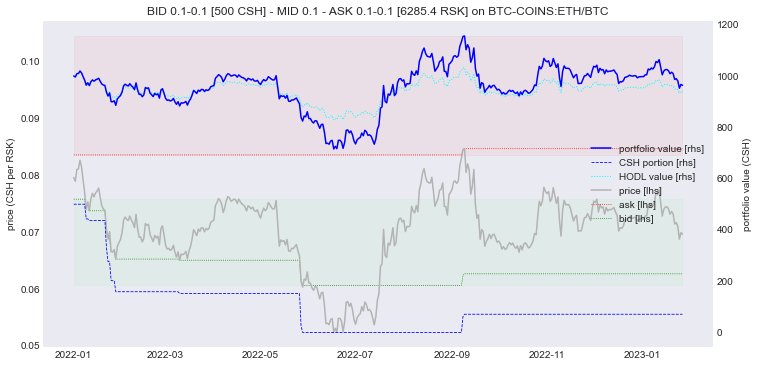

In [12]:
DATAID, DATAFN = datafn_w.value, j(DATAPATH, f"{datafn_w.value}.pickle") 
OUTPATH = outpath_w.value if output_w.values[0] else None
STARTPC, LENPC, SV, COLNM = segment_w.values[0], segment_w.values[1], strat1_w.values, datacols_w.value
path = pdread(DATAFN, COLNM, from_pc=STARTPC, period_pc=LENPC, min_dt=PATH_MIN_DATE)
strats["slider"] = strategy.from_mgw(m=100*SV[0], g=SV[1], w=SV[2], u=SV[3], amt_rsk=TVL/path[0]*(1-SV[4]), amt_csh=TVL*SV[4])
for ix, stratid in enumerate(strats_w.checked):
    strat = strats[stratid]
    simresults = run_sim(strat, path)
    plot_sim(simresults, f"{DATAID}:{COLNM}", Params(**params_w.values_dct))
    if isinstance(OUTPATH, str):
        plt.savefig(j(OUTPATH, fname(DATAID, COLNM)))
    plt.show()

Provide the corresponding box above (_"Show target directory listing"_) is checked, this will create a list of all `png` files generated throughout your analysis. Those files will only be generated is the box _"Save output to target directory"_ box is checked. The target directory is preset to the directory of this notebook, but you can change this in the code above. Keep in minds that if you run this analysis **on Binder, you have to download all files you want to keep before the server is destroyed.**

In [13]:
if OUTPATH and output_w.values[1]:
    print("Listing OUTPATH [uncheck box at top to disable]")
    print ("\n".join([fn[:-4] for fn in os.listdir(OUTPATH) if fn[-4:]==".png"]))

Listing OUTPATH [uncheck box at top to disable]
0127-215839-BTC-COINS-ETHBTC
0127-220213-BTC-COINS-ETHBTC
0127-215849-BTC-COINS-ETHBTC


Provide the corresponding box above (_"Generate docx & zip from charts"_) is checked, this code will create a Word `docx` file embedding all the `png` files in this folder.

In [14]:
if OUTPATH and output_w.values[2]:
    print("Creating consolidated docx and zip from charts [uncheck box at top to disable]")
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in [fn for fn in os.listdir(OUTPATH) if fn[-4:]==".png"])
    fsave(markdown, "_CHARTS.md", OUTPATH, quiet=True)
    !pandoc {OUTPATH}/_CHARTS.md -o {OUTPATH}/_CHARTS.docx
    !zip _CHARTS.zip -qq *.png 

Creating consolidated docx and zip from charts [uncheck box at top to disable]
